# Algortimos Clásicos para la Resolución del Problema del Viajante del Comercio

En este jupyter notebooks, se van a resolver diferentes TSP con algoritmos clásicos para analizar y estudiar las distintas soluciones que otorgan. 

* Preparación del Entorno: 

In [61]:
# Creación de la base de datos 
import dataset
import importlib
importlib.reload(dataset)
from dataset import DatasetCreation

# llamada a Algortimos Clásicos de resolución del TSP 
import classic_algorithms
importlib.reload(classic_algorithms)
from classic_algorithms import classic_algorithms, AntColonyOptimizer, GeneticAlgorithm

# ----- Librerias Necesarias ----- # 
from torch_geometric.data import Data
import itertools
import torch
import numpy as np 
import matplotlib.pyplot as plt
import gzip, urllib.request
from tsplib95 import load
import math
import time

1. Se crea una base de datos de problemas con tamaños de nodos que van desde 5 hasta 20, con el fin de analizar cómo el tiempo de ejecución aumenta de manera exponencial en función del número de nodos

In [3]:
# Creacion de la base de datos para probar los algoritmos clásicos del TSP 
TSPs = []

num_datasets = 1

for num_nodes in range(5, 20):
  node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = DatasetCreation.create_dataset(num_nodes = num_nodes,  num_datasets = num_datasets)

  # Peso para el entrenamiento de la red neuronal, mayor número de nodos mayor peso tiene en el entrenamiento. 
  num_pos = num_nodes
  num_neg = num_nodes**2-num_nodes

  weight_pos_class = (num_neg/num_pos)

  edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
  for i in range(len(node_coords)):
      edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

      x = torch.tensor(node_coords[i]).float()
      y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)

      data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
      data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
      data.true_path = torch.Tensor(solution_paths[i])
      data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
      data.num_nodes = num_nodes
      data.pos_class_weight = weight_pos_class
      data.distance_matrices = distance_matrices
      TSPs.append(data)

In [ ]:
# Ejemplo de la información que tenemos de para cada problema
ejemplo = TSPs[1]
print("Nodos del problema:")
print(ejemplo.x.tolist())
print("\nAristas por donde pasa el tour (1 si para , 0 si no pasa):")
print(ejemplo.y.tolist())
print("\nCamino más corto")
print(ejemplo.true_path.tolist())
print("\nDistancia total del tour:")
print(ejemplo.true_distance.tolist())
print("\nPeso para la red neuronal:")
print(ejemplo.pos_class_weight)
print("\nMatriz de distancias:")
print(ejemplo.distance_matrices)

Nodos del problema:
[[42.891632080078125, 34.145912170410156], [64.60655975341797, 78.26953125], [75.73906707763672, 31.29979705810547], [95.47655487060547, 87.16954803466797], [83.4342041015625, 78.91610717773438], [46.335018157958984, 50.57246780395508]]

Aristas por donde pasa el tour (1 si para , 0 si no pasa):
[[0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

Camino más corto
[0.0, 2.0, 3.0, 4.0, 1.0, 5.0]

Distancia total del tour:
[[175.626708984375]]

Peso para la red neuronal:
5.0

Matriz de distancias:
[array([[ 0.        , 49.17755454, 32.97050783, 74.67717445, 60.39925869,
        16.78358012],
       [49.17755454,  0.        , 48.27099527, 32.12735674, 18.83874432,
        33.18096883],
       [32.97050783, 48.27099527,  0.        , 59.25367513, 48.2340989 ,
        35.157

2. Estudio del algoritmo de **Fuerza Bruta** para la resolución del TSP. Únicamente lo probamos con problemas de tamaño menores a 12, debido al coste computacional que requiere.

In [29]:
sizes = []
times = []

for tsp in TSPs[:7]:
    nodes = tsp.x
    dist_matrix = tsp.distance_matrices[0]
    _, _, elapsed = classic_algorithms.brute_force(nodes, dist_matrix)
    sizes.append(len(nodes))
    times.append(elapsed)

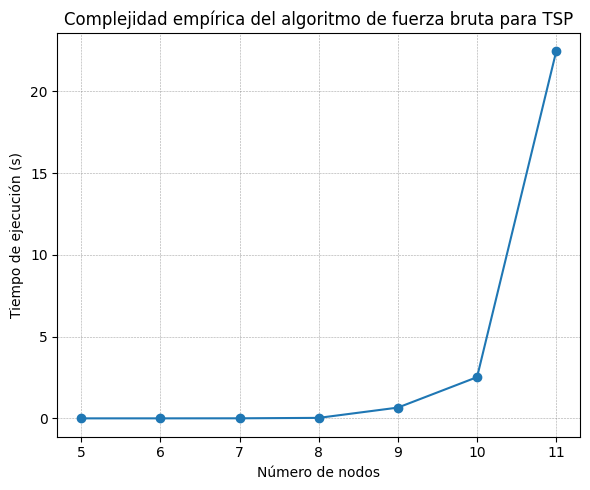

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(sizes, times, marker='o')
ax.set_xlabel('Número de nodos')
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Complejidad empírica del algoritmo de fuerza bruta para TSP')


ax.grid(
    True,
    color='gray',
    linestyle='--',
    linewidth=0.4,
    alpha=0.7
)

fig.tight_layout()
plt.show()


3. Estudio del algortimo de progrmación dinámica, **Held-Karp**: 

In [37]:
sizes = []
times = []

for tsp in TSPs:
    nodes = tsp.x
    dist_matrix = tsp.distance_matrices[0]
    _, _, elapsed = classic_algorithms.held_karp(nodes, dist_matrix)
    sizes.append(len(nodes))
    times.append(elapsed)

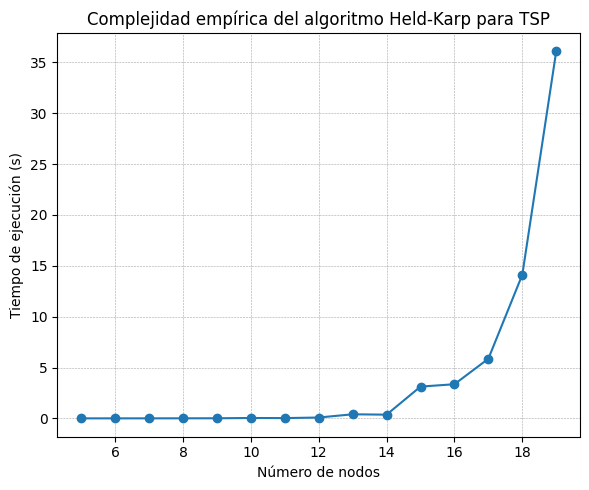

In [38]:
fig, ax = plt.subplots(figsize=(6, 5))

plt.plot(sizes, times, marker='o')
plt.xlabel('Número de nodos')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Complejidad empírica del algoritmo Held-Karp para TSP')
ax.grid(
    True,
    color='gray',
    linestyle='--',
    linewidth=0.4,
    alpha=0.7
)

fig.tight_layout()
plt.show()

**Análisis de los Algoritmos Heurísticos**

Para estos algoritmos es necesario el uso de problemas de mayor tamaño. Primero vamos a trabajar con *rl11849* que consta de 11.849 nodos

In [67]:
problem = load('TSP_problems/rl11849.tsp')
print("Nodos:", len(list(problem.get_nodes())))
tour_rl = 923288 # Ruta óptima del problema rl11849
print("ruta óptima:", tour_rl)

Nodos: 11849
ruta óptima: 923288


In [ ]:
# 1) Parsear coordenadas (igual que antes)
coords = {}
with open('rl11849.tsp', 'r') as f:
    in_section = False
    for line in f:
        line = line.strip()
        if line.startswith('NODE_COORD_SECTION'):
            in_section = True
            continue
        if in_section:
            if line in ('EOF', 'DISPLAY_DATA_SECTION'):
                break
            idx, x, y = line.split()[:3]
            coords[int(idx)] = (float(x), float(y))

nodes = sorted(coords)
N = len(nodes)

# 2) Función de distancia Euclidiana redondeada
def euclid(i, j):
    xi, yi = coords[i]
    xj, yj = coords[j]
    return int(math.hypot(xi - xj, yi - yj) + 0.5)

# 3) Construir la “mitad inferior” de la matriz
distance_lower = [
    [euclid(nodes[i], nodes[j]) for j in range(i+1)]
    for i in range(N)
]

# 4) ¿Cómo acceder a la distancia entre nodes[a] y nodes[b]?
def dist(a_idx, b_idx):
    i, j = max(a_idx, b_idx), min(a_idx, b_idx)
    return distance_lower[i][j]



Almacenadas 70205325 entradas en lugar de 140398801.
4236


In [15]:
# Supongamos que ya tienes tu dict coords:
# coords = {1: (7840.0, 4708.0), 2: (15408.0, 7876.0), 3: (11915.0, 4774.0), …}

# 1) Ordena las claves (nodos)
nodes = sorted(coords.keys())

# 2) Construye la lista de pares [x, y]
coords_list = [[coords[i][0], coords[i][1]] for i in nodes]

print(coords_list[:4])
# → [[7840.0, 4708.0], [15408.0, 7876.0], [11915.0, 4774.0], […]]

[[7840.0, 4708.0], [15408.0, 7876.0], [11915.0, 4774.0], [3280.0, 12826.0]]


In [ ]:
# distance_lower es la lista de listas tal que
# distance_lower[i][j] = d(i,j) para j ≤ i, y no existe para j > i

N = len(distance_lower)

# 1) Inicializa la matriz completa con ceros
distance_full = [[0]*N for _ in range(N)]

# 2) Rellena ambas mitades
for i in range(N):
    for j in range(i+1):
        d = distance_lower[i][j]
        distance_full[i][j] = d
        distance_full[j][i] = d

# Ahora distance_full[i][j] == distance_full[j][i] == distance_lower[max(i,j)][min(i,j)]

In [19]:
# Supongamos que distance_full es tu matriz N×N como lista de listas
N_filas = len(distance_full)
N_columnas = len(distance_full[0])    # asumiendo que todas las filas tienen la misma longitud

print(f"La matriz tiene {N_filas} filas y {N_columnas} columnas.")


D = np.array(distance_full, dtype=np.int32)  # ahora D.shape == (N, N)

La matriz tiene 11849 filas y 11849 columnas.


4. Análisis del algoritmo **Vecino más Cercano**: 

In [25]:
ruta, coste, tiempo = classic_algorithms.nearest_neighbor(coords_list,D)
print("Ruta óptima (índices):", ruta)
print("Coste total:", coste)
print(f"Tiempo de ejecución: {tiempo:.4f} s")

Ruta óptima (índices): [0, 11409, 8532, 9472, 8295, 8489, 11747, 1202, 10731, 9962, 4180, 3521, 2513, 11424, 8116, 5959, 3476, 11670, 4726, 11511, 9593, 54, 6246, 4721, 4437, 8833, 8228, 212, 7590, 2749, 107, 7517, 2982, 11758, 8387, 3210, 693, 7589, 9760, 9461, 7812, 7211, 11447, 8825, 10860, 6739, 9225, 11632, 1815, 2380, 2957, 4188, 8793, 3607, 3347, 8413, 1982, 5600, 2201, 2492, 7779, 11840, 3603, 9152, 3191, 4840, 2057, 4158, 11084, 829, 2672, 584, 6878, 1557, 7709, 6603, 4296, 213, 2978, 9138, 9255, 4992, 9093, 5702, 6829, 3263, 4581, 6536, 11433, 5926, 158, 1073, 603, 3349, 11406, 1673, 8667, 905, 10893, 2323, 11814, 4033, 11684, 3700, 11572, 9932, 1590, 5027, 52, 4582, 7402, 11009, 1312, 10650, 8771, 5809, 8519, 1725, 8905, 10358, 474, 5175, 678, 3077, 5262, 9896, 11796, 11454, 866, 770, 8147, 10759, 6874, 1500, 11179, 10933, 4265, 3945, 1798, 11474, 5286, 8020, 10027, 11686, 9982, 5777, 1950, 3414, 6466, 7983, 7401, 6615, 9, 1259, 8199, 9168, 7878, 448, 3796, 6074, 7251, 1670,

In [26]:
coste_optimo = tour_rl   # renombra para mayor claridad
porcentaje_error = (coste - coste_optimo) / coste_optimo * 100
print(f"Error porcentual respecto al óptimo: {porcentaje_error:.2f}%")

Error porcentual respecto al óptimo: 21.87%


5. Análisis del algortimo **ACO**: 

In [ ]:
# Crear y ejecutar ACO
aco = AntColonyOptimizer(
    distance_matrix=D,
    n_ants=10,
    n_best=5,
    n_iterations=10,
    decay=0.5,
    alpha=1,
    beta=2.5
)

# Ya no necesitas tu timing exterior, lo devuelve ACO.run()
best_route, best_cost, elapsed = aco.run()

# print("Ruta óptima encontrada:", best_route)
print("Coste óptimo encontrado:", best_cost)
print(f"Tiempo de ejecución total (desde run): {elapsed:.4f} s")


Iter 1/10, best_cost: 2249295
Iter 2/10, best_cost: 2249295
Iter 3/10, best_cost: 2249295
Iter 4/10, best_cost: 2249295
Iter 5/10, best_cost: 2245131
Iter 6/10, best_cost: 2165251
Iter 7/10, best_cost: 2165251
Iter 8/10, best_cost: 2139008
Iter 9/10, best_cost: 2024526
Iter 10/10, best_cost: 1899551
Ruta óptima encontrada: [9968, np.int64(2631), np.int64(3461), np.int64(9342), np.int64(6224), np.int64(3859), np.int64(8073), np.int64(5373), np.int64(2022), np.int64(5075), np.int64(5891), np.int64(6166), np.int64(3462), np.int64(5622), np.int64(11752), np.int64(8687), np.int64(6985), np.int64(10976), np.int64(11531), np.int64(5975), np.int64(8262), np.int64(7229), np.int64(7622), np.int64(8896), np.int64(4988), np.int64(4786), np.int64(7642), np.int64(3708), np.int64(8562), np.int64(2744), np.int64(66), np.int64(10996), np.int64(4128), np.int64(9978), np.int64(2161), np.int64(739), np.int64(6670), np.int64(1760), np.int64(6387), np.int64(1255), np.int64(4166), np.int64(8306), np.int64(74

In [51]:
coste_optimo = tour_rl   # renombra para mayor claridad
porcentaje_error = (best_cost - coste_optimo) / coste_optimo * 100
print(f"Error porcentual respecto al óptimo: {porcentaje_error:.2f}%")

Error porcentual respecto al óptimo: 105.74%


6. Análisis con **Algortimos Genéticos**:

In [64]:
# ga = GeneticAlgorithm(
#     distance_matrix=D,
#     population_size=100,
#     elite_size=20,
#     mutation_rate=0.1,
#     generations=10
# )
ga = GeneticAlgorithm(
  distance_matrix=D, 
  population_size= 100, 
  elite_size=40,
  mutation_rate=0.02, 
  generations=20,
  tournament_size=7
)

route, cost, elapsed = ga.run()
# print("Best route:", route)
print("Best cost:", cost)
print(f"Tiempo total GA: {elapsed:.4f} s")

Gen 1/20, best dist: 86220298
Gen 2/20, best dist: 86003732
Gen 3/20, best dist: 85740767
Gen 4/20, best dist: 85740767
Gen 5/20, best dist: 85740767
Gen 6/20, best dist: 85740767
Gen 7/20, best dist: 85740767
Gen 8/20, best dist: 85740767
Gen 9/20, best dist: 85740767
Gen 10/20, best dist: 85740767
Gen 11/20, best dist: 85740767
Gen 12/20, best dist: 85740767
Gen 13/20, best dist: 85740767
Gen 14/20, best dist: 85740767
Gen 15/20, best dist: 85740767
Gen 16/20, best dist: 85740767
Gen 17/20, best dist: 85740767
Gen 18/20, best dist: 85740767
Gen 19/20, best dist: 85740767
Gen 20/20, best dist: 85740767
Best cost: 85740767
Tiempo total GA: 254.0923 s


Ruta óptima (índices): [0, 11409, 8532, 9472, 8295, 8489, 11747, 1202, 10731, 9962, 4180, 3521, 2513, 11424, 8116, 5959, 3476, 11670, 4726, 11511, 9593, 54, 6246, 4721, 4437, 8833, 8228, 212, 7590, 2749, 107, 7517, 2982, 11758, 8387, 3210, 693, 7589, 9760, 9461, 7812, 7211, 11447, 8825, 10860, 6739, 9225, 11632, 1815, 2380, 2957, 4188, 8793, 3607, 3347, 8413, 1982, 5600, 2201, 2492, 7779, 11840, 3603, 9152, 3191, 4840, 2057, 4158, 11084, 829, 2672, 584, 6878, 1557, 7709, 6603, 4296, 213, 2978, 9138, 9255, 4992, 9093, 5702, 6829, 3263, 4581, 6536, 11433, 5926, 158, 1073, 603, 3349, 11406, 1673, 8667, 905, 10893, 2323, 11814, 4033, 11684, 3700, 11572, 9932, 1590, 5027, 52, 4582, 7402, 11009, 1312, 10650, 8771, 5809, 8519, 1725, 8905, 10358, 474, 5175, 678, 3077, 5262, 9896, 11796, 11454, 866, 770, 8147, 10759, 6874, 1500, 11179, 10933, 4265, 3945, 1798, 11474, 5286, 8020, 10027, 11686, 9982, 5777, 1950, 3414, 6466, 7983, 7401, 6615, 9, 1259, 8199, 9168, 7878, 448, 3796, 6074, 7251, 1670,